# TP03: Restauration D'images
### Ahmed Ben Saad

## I. Altération d'une image

In [13]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse.linalg import cg

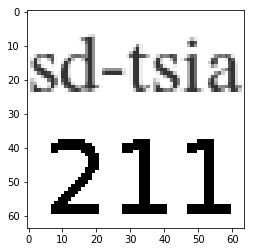

In [14]:
path='' #change for filepath
#open file
data = pickle.load(open(path+'data2018forpython2.pk','rb'))
#load the original image
X=data.get('original')
#plot image
plt.imshow(X,cmap='gray')
plt.show()

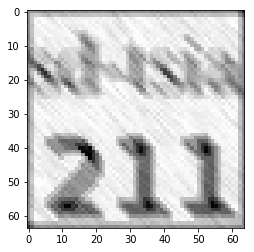

In [15]:
H=data.get('H')
h=H.toarray()
#X=np.reshape(X,(4096,1))
#XX=H*X
#XX=XX.reshape((64,64))
XX=data.get('observations')
plt.imshow(XX,cmap='gray')
plt.show()

## II. Restauration d'image par l'algorithme ADMM


### Préparation 1

# TODO REP SUR QUESTION

### Préparation 2

# TODO REP SUR QUESTION

### Préparation 3

In [16]:
T=data.get('T')
T=T.toarray()
p=4096

In [17]:
def argmin_x(x,z1,z2,g1,g2,rho,y):
    M= np.dot(np.transpose(h),h)+ rho*np.dot(np.transpose(T),T)+rho*np.eye(p)
    B=(rho*(z1+np.dot(np.transpose(T),z2))) + (np.dot(np.transpose(h),y)) - g1 - (np.dot(np.transpose(T),g2))
    x=(cg(M,B)[0]).reshape((4096,1))
    return x

### Préparation 4

# TODO TROUVER LA FORMULE DE Zk+1

In [18]:
def argmin_z1(x,rho,g1):
    minn=np.minimum(1.,(1./rho)*g1+x)
    maxx=np.maximum(0.,minn)
    return(maxx)

# TODO TROUVER LA FORMULE DE Z2 k+1

In [19]:
def seuillage_doux(z, seuil):
    if (z > seuil):
        z -= seuil
    if (z < -seuil):
        z += seuil
    if (z<=seuil and z>=-seuil):
        z = 0
    return z

In [26]:
def argmin_z2(x,rho,g2,beta,T):
    Tx=np.dot(T,x)
    #rhog=(1./rho)*g2
    #return((Tx+rhog)*np.maximum(0.0,1.0-(1./rho)*beta/np.linalg.norm(Tx+rhog)))
    z2 = Tx + g2/rho
    for i in range(len(z2)):
        z2[i] = seuillage_doux(z2[i], beta/rho)
    return z2


### Préparation 5

In [27]:
def maj_g1_g2(x,z1,z2,rho,g1,g2,T):
    new_g1=g1+rho*(x-z1)
    new_g2=g2+rho*(T.dot(x)-z2)
    return (new_g1,new_g2)
    
    

## III. Implémentation de l'ADMM pour résoudre le problème de restauration d'image


In [64]:
rho=0.05
beta=0.01
kmax=100
X_Original = X.reshape((4096,1))

In [65]:
def ADMM(rho,beta):
    y=np.reshape(XX,(4096,1))
    x=np.zeros((4096,1))
    z1=x
    z2=T.dot(x)
    g1=x
    g2=np.zeros((4096*2-64-64,1))
    eqm=[]
    #biais=[]
    L=[]
    for i in range(kmax):
        x=argmin_x(x,z1,z2,g1,g2,rho,y)
        z1=argmin_z1(x,rho,g1)
        z2=argmin_z2(x,rho,g2,beta,T)
        g1,g2=maj_g1_g2(x,z1,z2,rho,g1,g2,T)
        eqm.append(np.mean((x-X_Original)*(x-X_Original)))
        #biais.append(np.mean(y-x))
        L_1= 0.5*(np.linalg.norm(y-np.dot(h,x)))**2
        L_2=beta*np.linalg.norm(z2,ord=1)
        L_3=np.sum(g1*(x-z1))
        L_4=np.sum(g2*(T.dot(x)-z2))
        L_5=0.5*rho*(np.linalg.norm(x-z1))**2
        L_6=0.5*rho*(np.linalg.norm(np.dot(T,x)-z2))**2
        L.append( L_1 + L_2 + L_3 + L_4 + L_5 + L_6 )
        #L.append(np.sum((h.dot(x)-y)*(h.dot(x)-y))/2.+beta*np.sum(np.fabs(z2))+np.sum(g1*(x-z1)) + np.sum(g2*(T.dot(x)-z2)) + \
        #   rho*np.sum((x-z1)*(x-z1))/2. + rho*np.sum((T.dot(x)-z2)*(T.dot(x)-z2))/2.)
    x=x.reshape(64,64)
    plt.title("rho = %f, beta= %f" %(rho, beta))  
    plt.imshow(x,cmap='gray')
    plt.show()
    return(x,y,eqm,L)

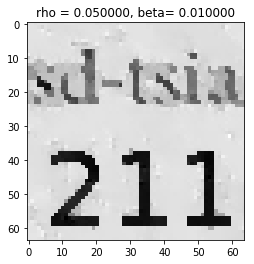

In [66]:
x,y,eqm,L = ADMM(rho,beta)

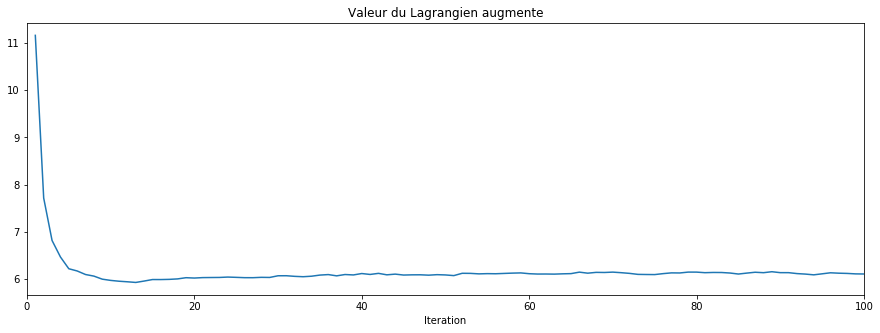

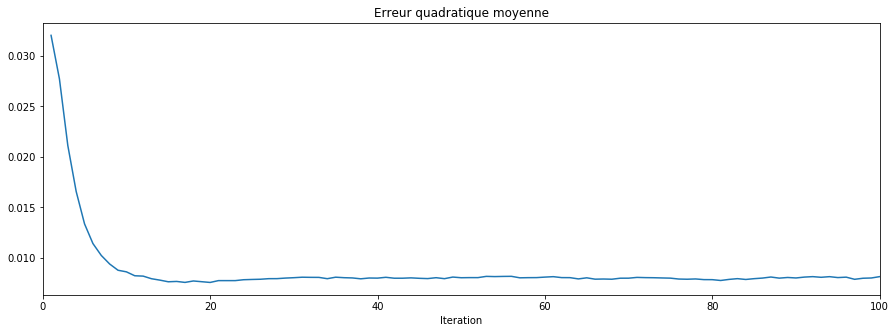

In [67]:
abscisse = range(1, kmax+1)
plt.figure(3, figsize=(15, 5))
plt.title("Valeur du Lagrangien augmente")
plt.plot(abscisse, L)
plt.xlabel("Iteration")
plt.xlim(0, 100)
plt.show()
plt.figure(3, figsize=(15, 5))
plt.title("Erreur quadratique moyenne")
plt.plot(abscisse, eqm)
plt.xlabel("Iteration")
plt.xlim(0, 100)
plt.show()

On remarque  que 20 itérations sont suffisantes pour que l'erreur et le lagrangien convergent. Pour la suite on va prendre kmax = 20.

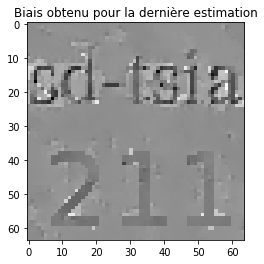

In [68]:
biais = X - x 
plt.imshow(biais, cmap='gray')
plt.title("Biais obtenu pour la dernière estimation")
plt.show()

### Influence de Rho et de Beta:

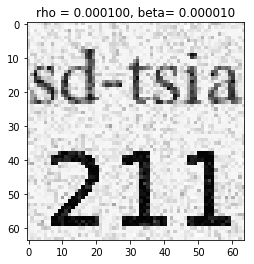

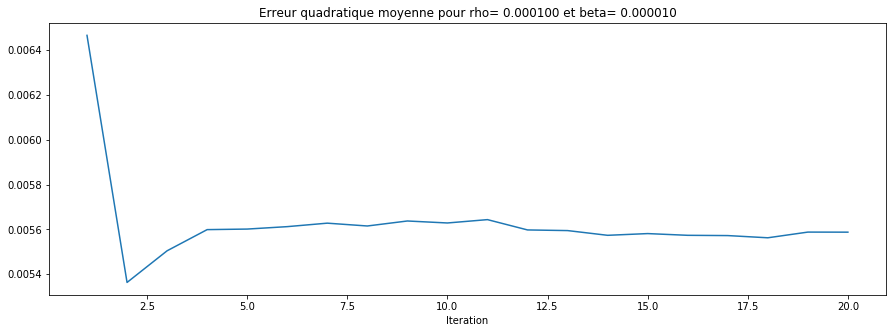

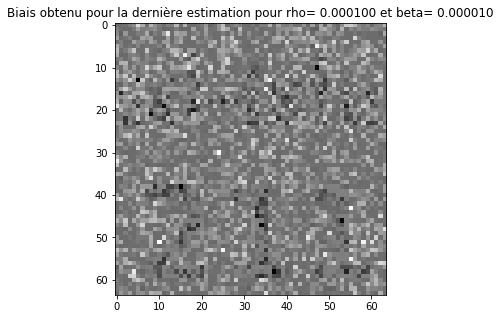

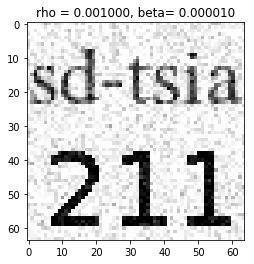

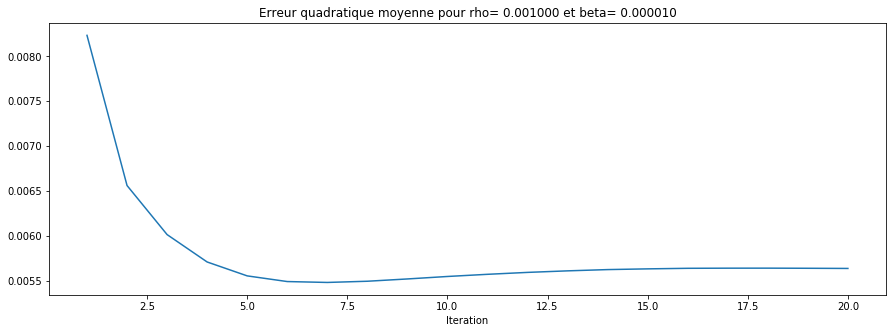

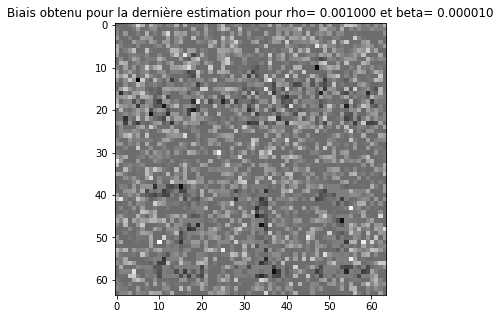

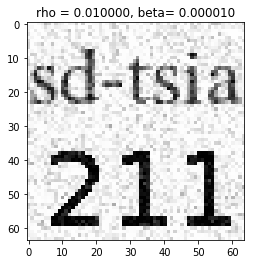

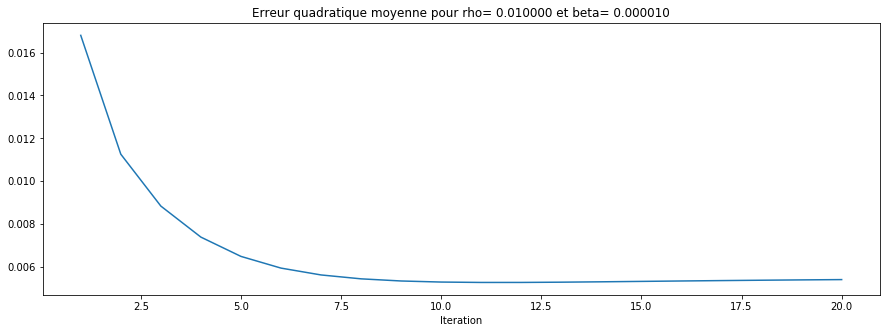

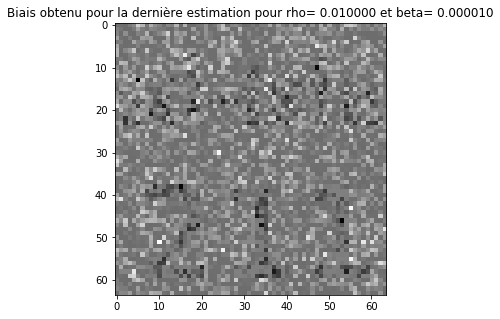

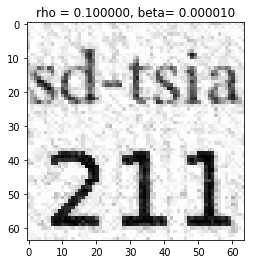

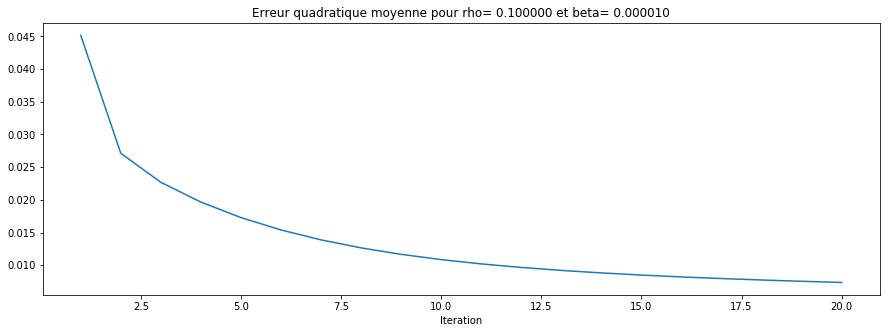

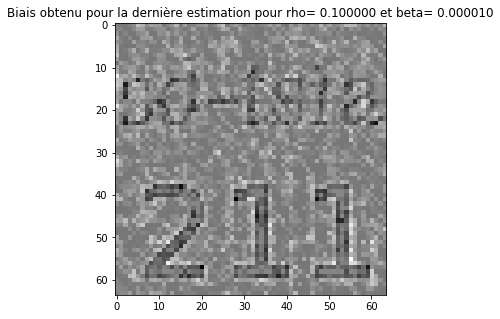

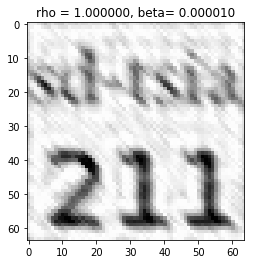

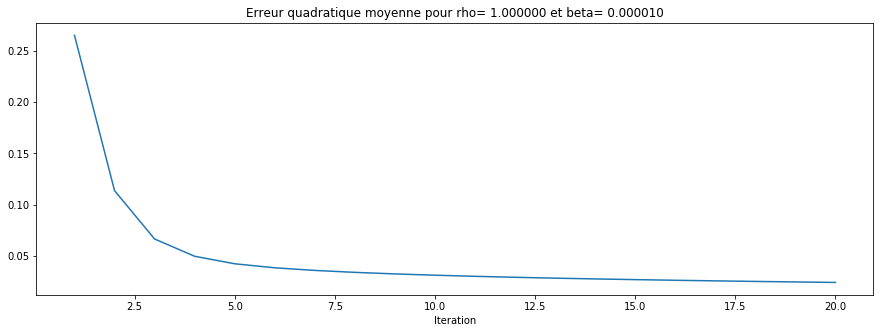

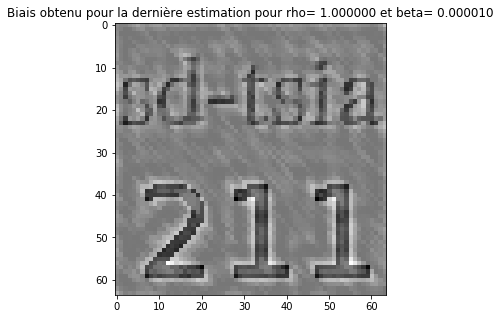

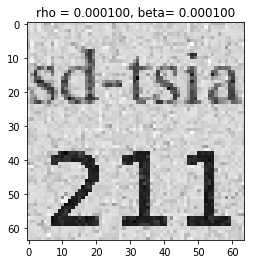

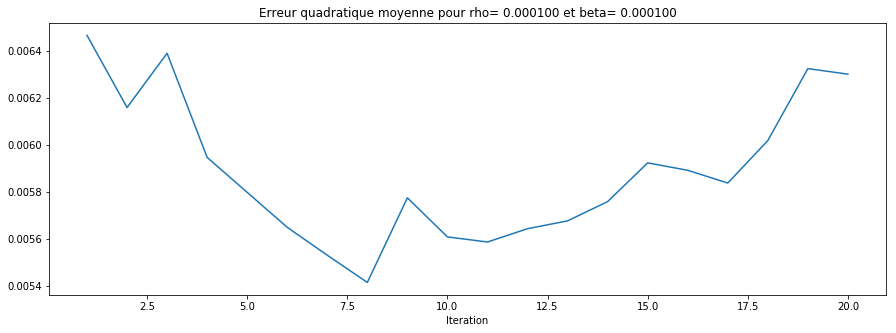

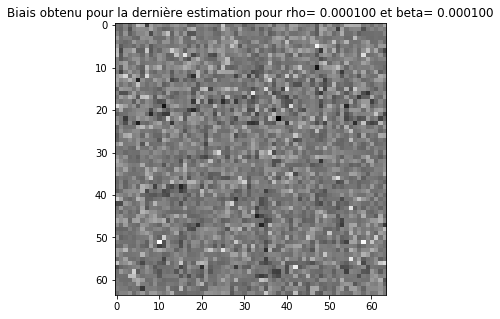

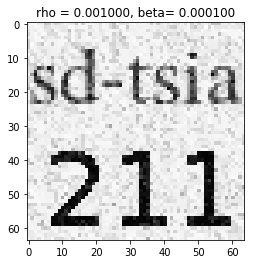

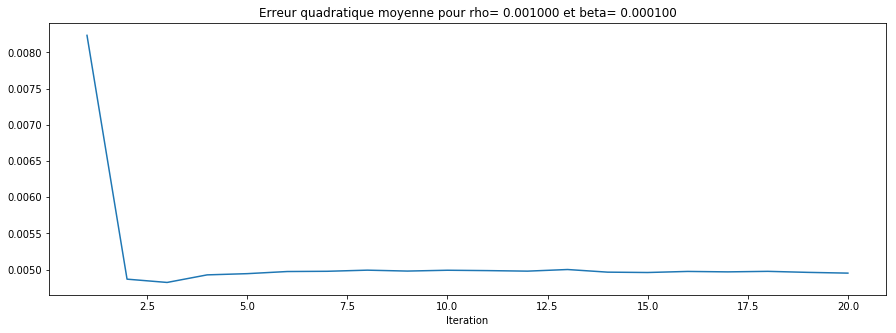

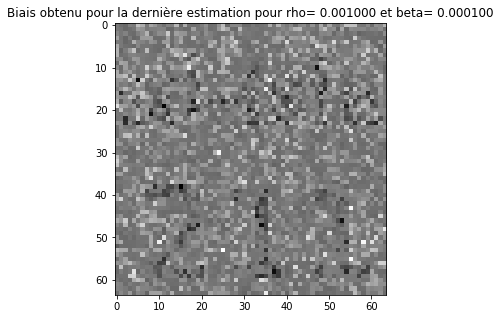

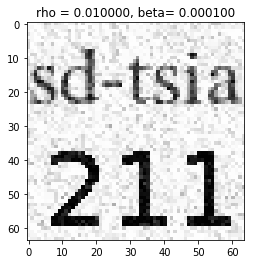

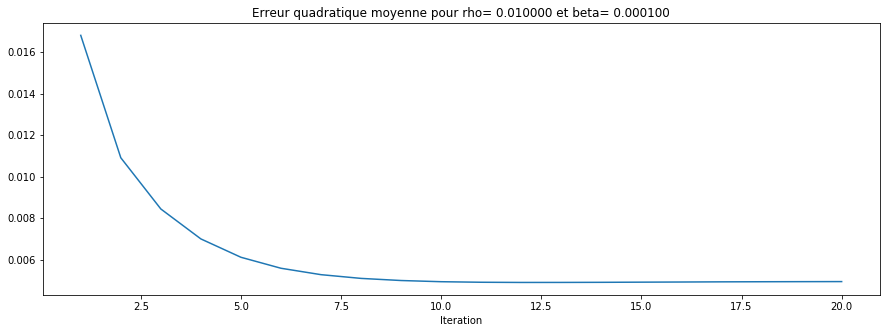

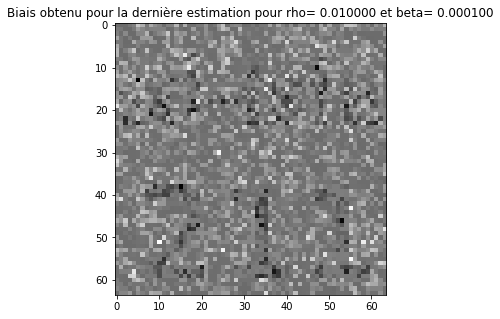

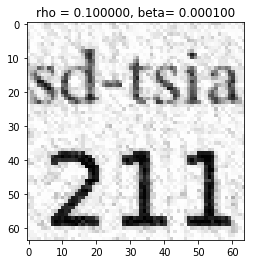

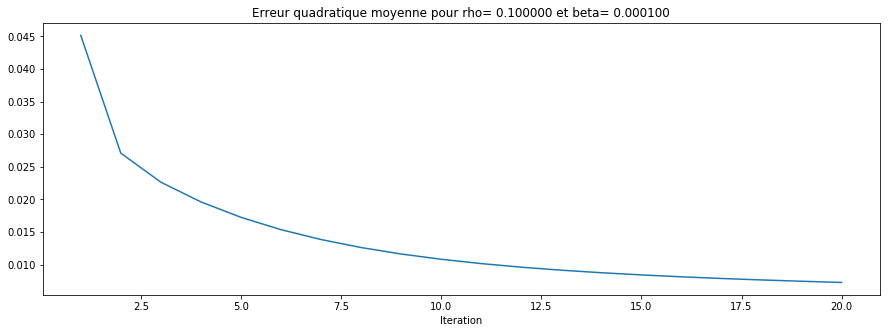

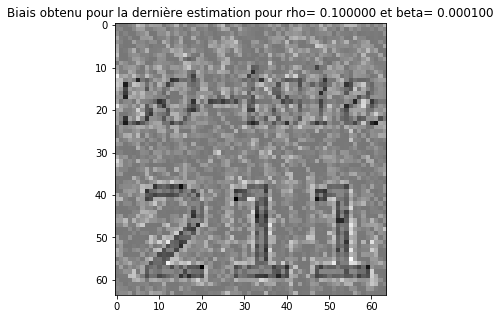

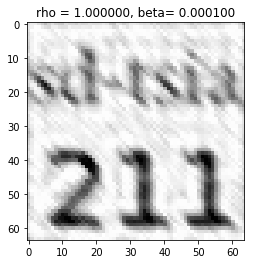

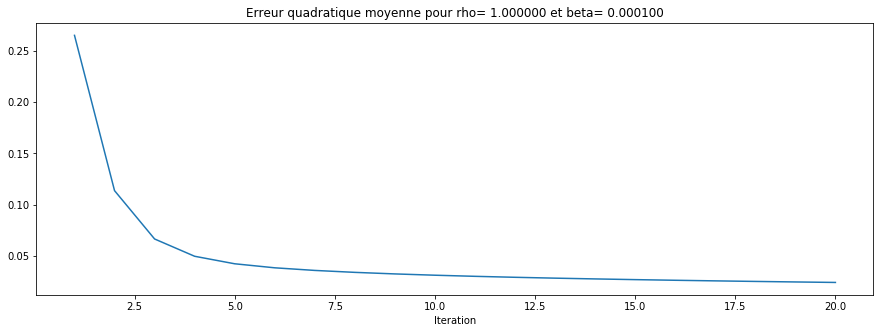

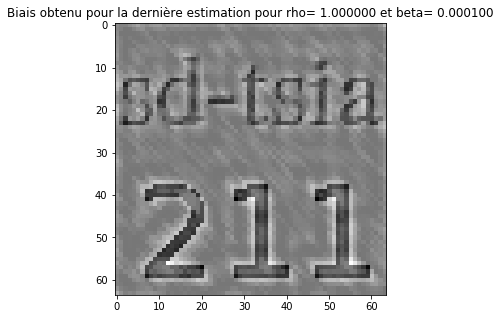

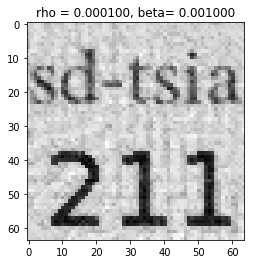

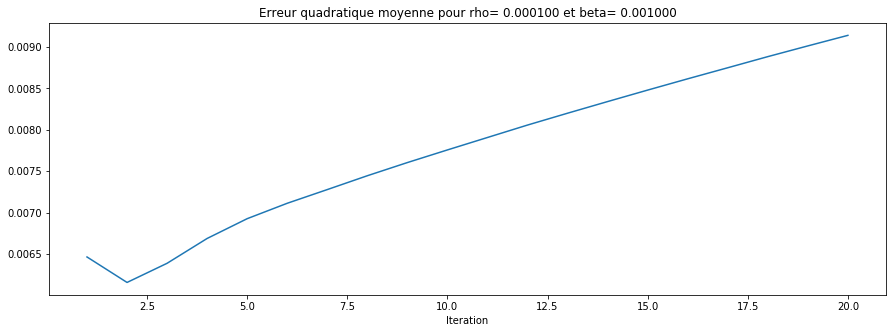

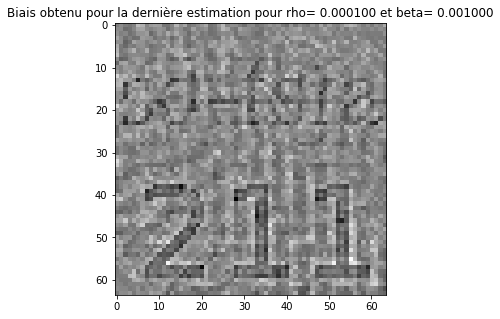

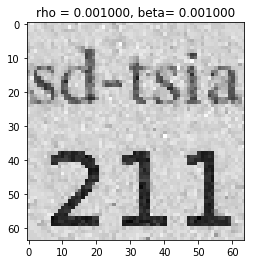

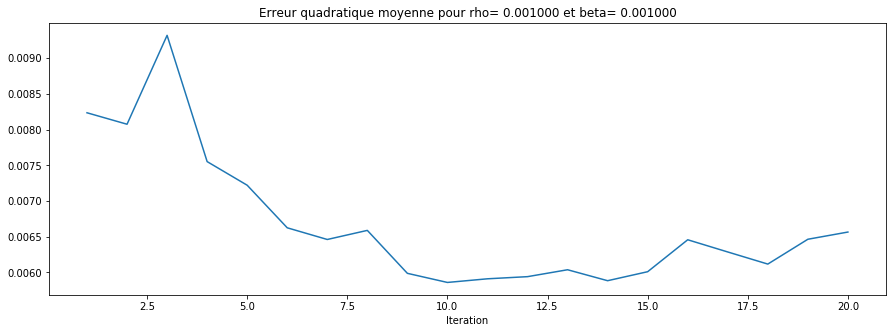

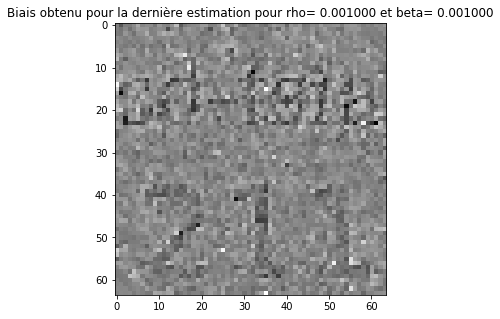

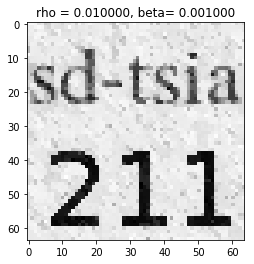

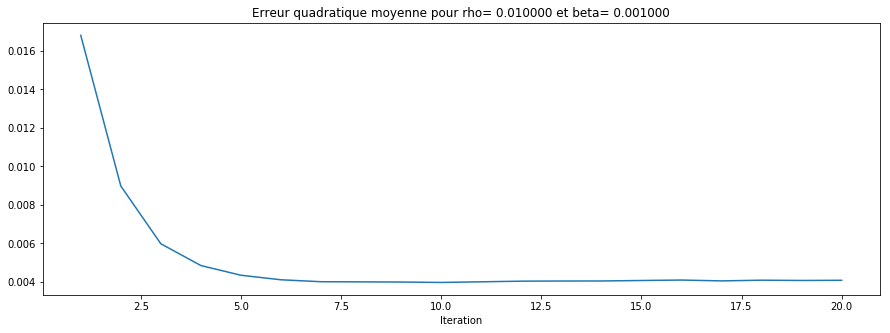

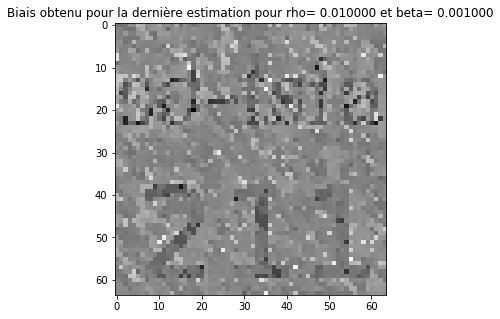

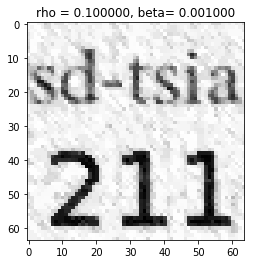

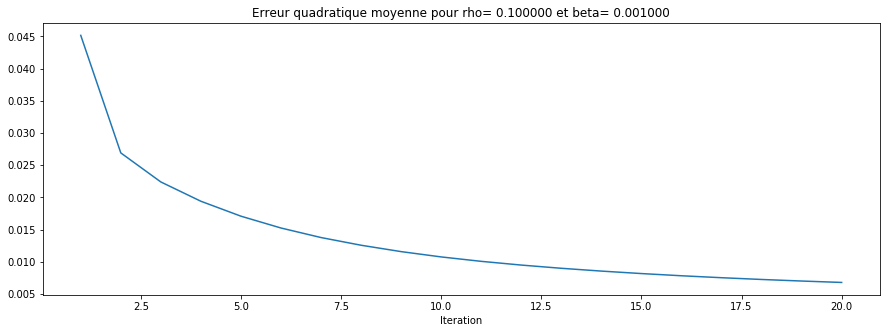

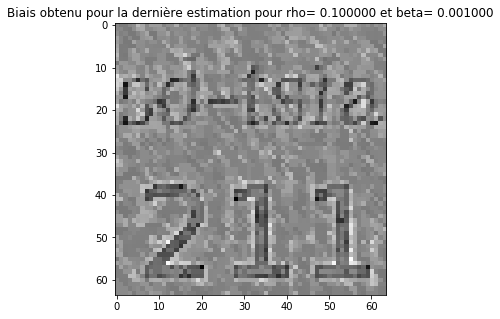

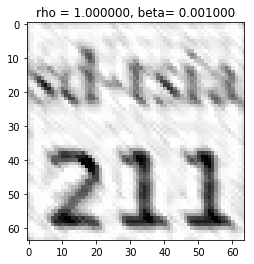

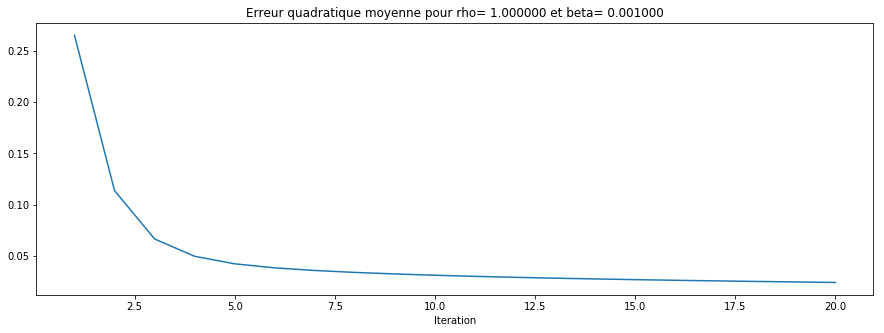

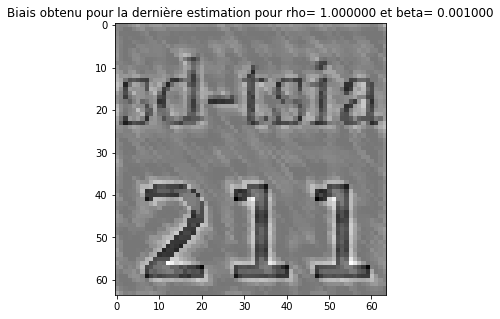

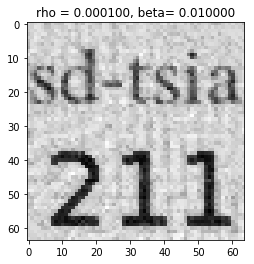

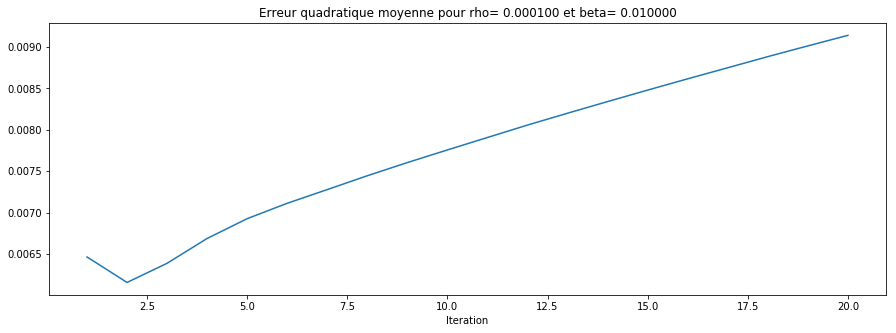

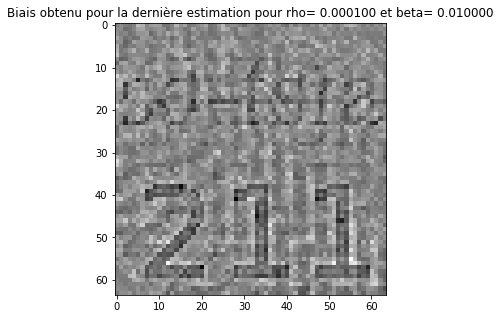

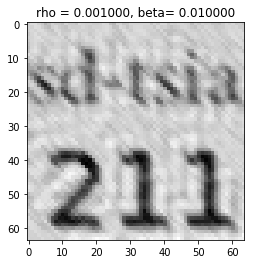

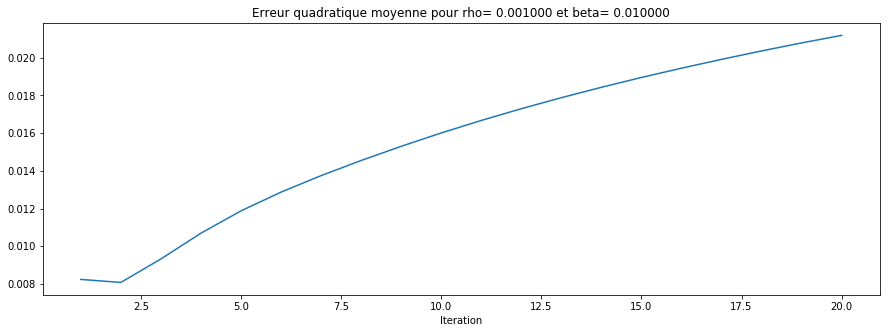

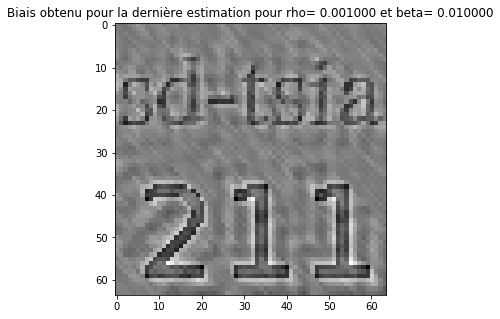

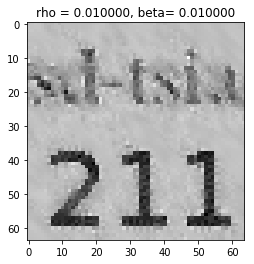

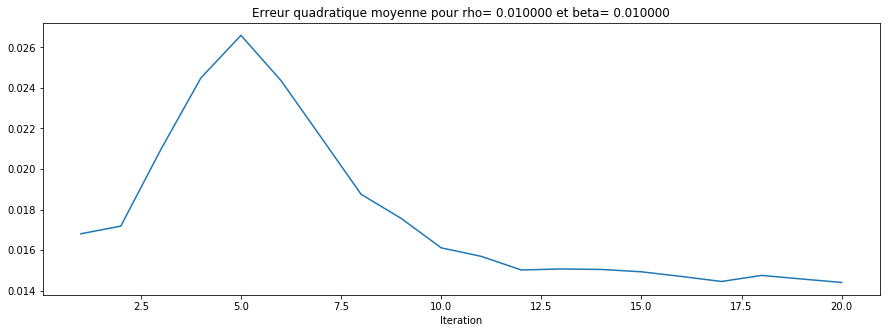

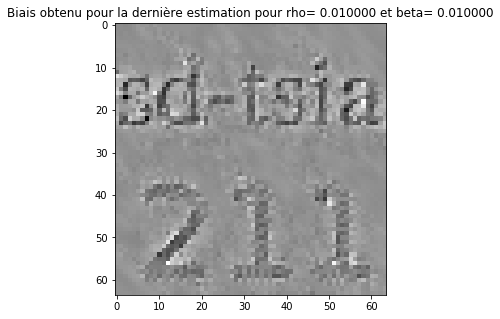

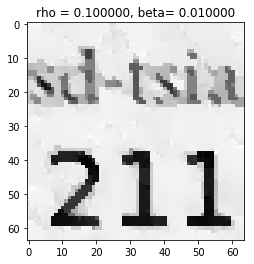

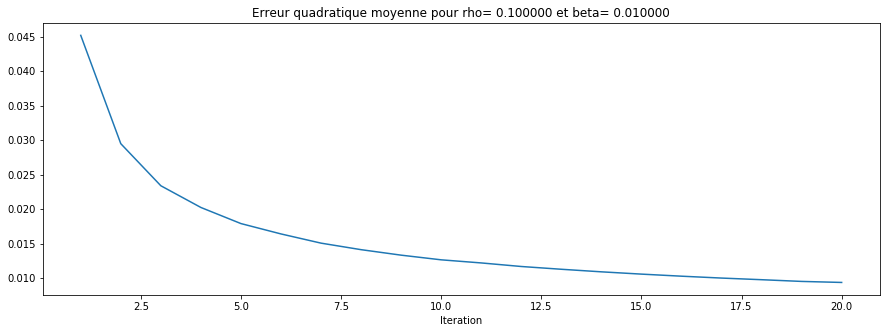

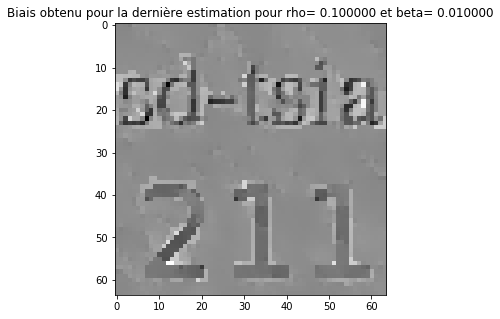

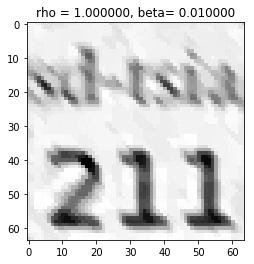

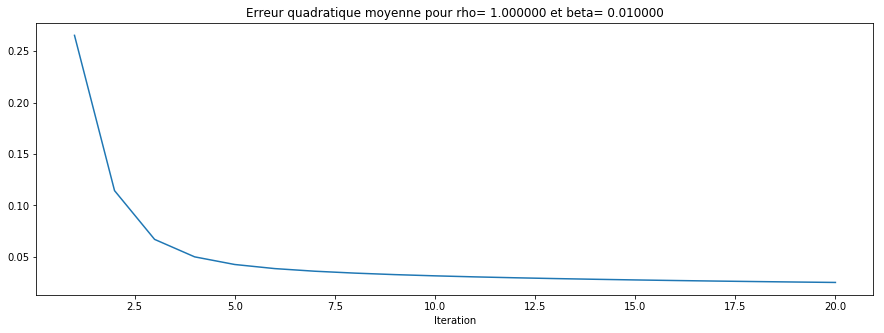

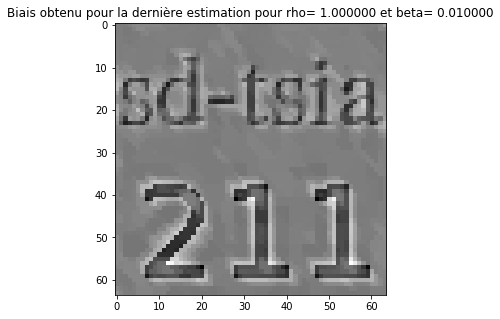

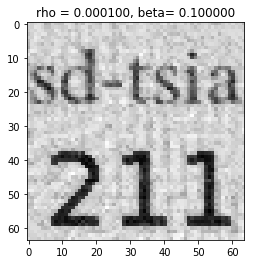

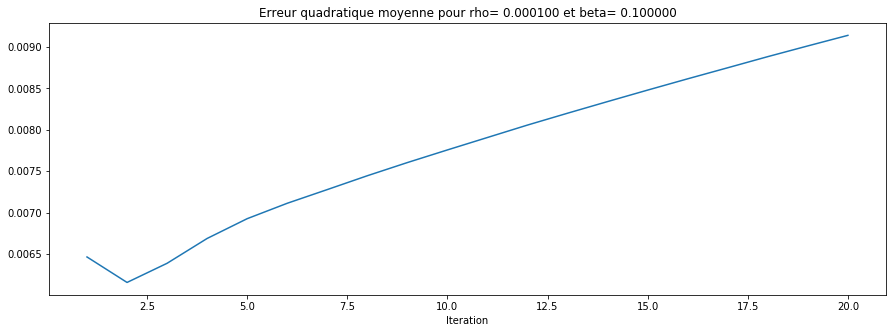

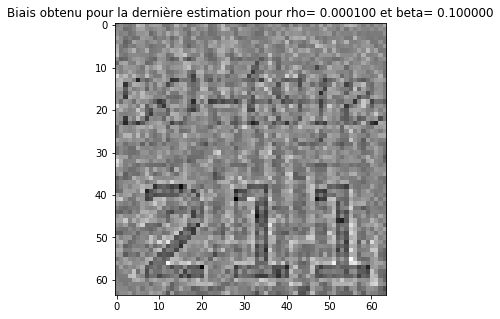

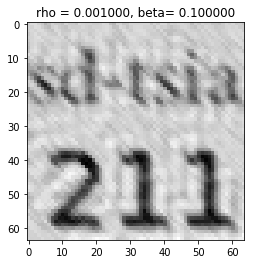

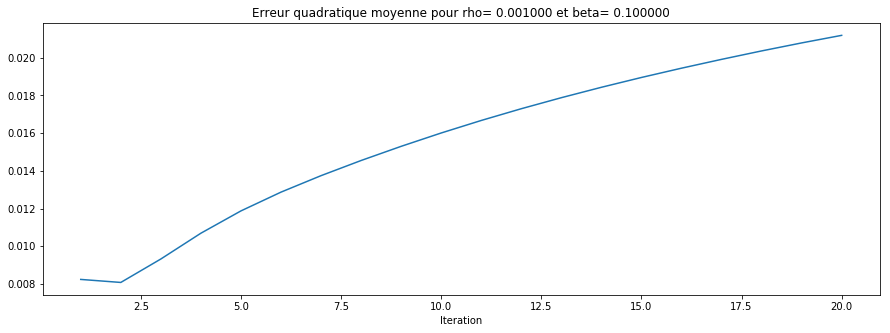

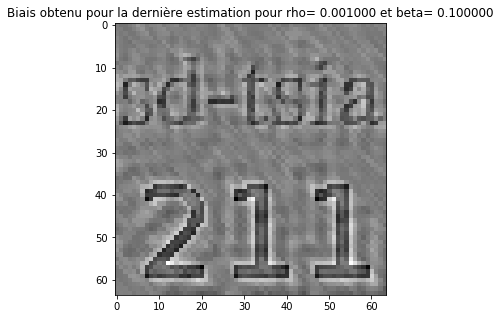

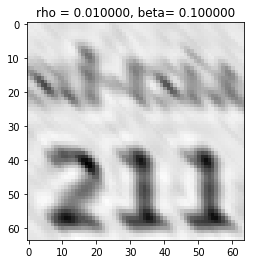

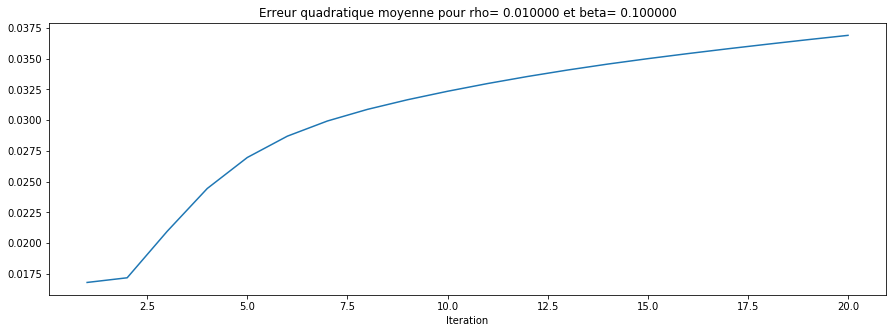

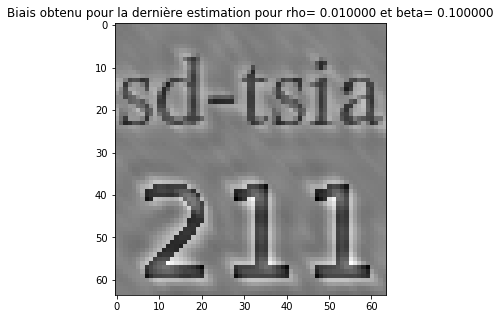

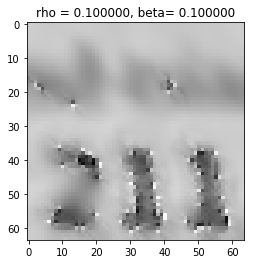

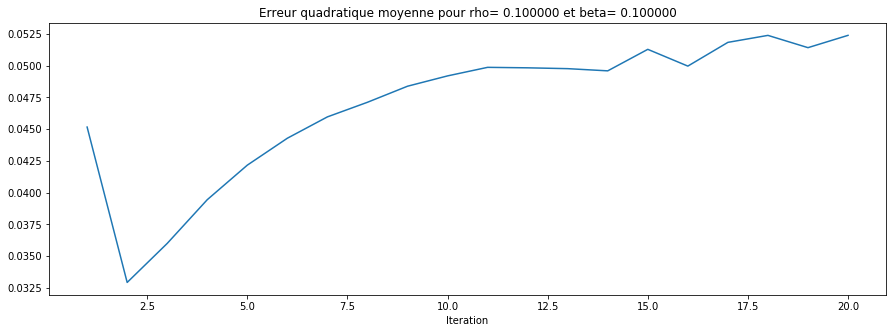

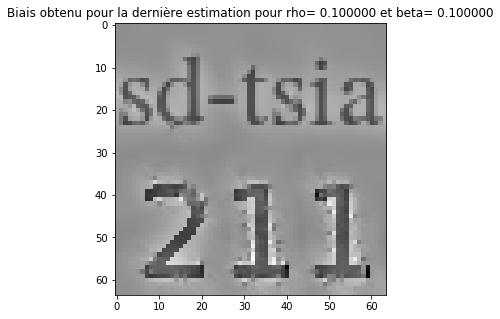

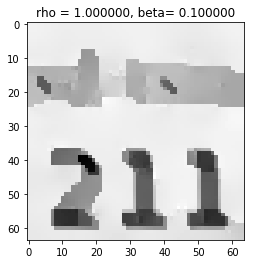

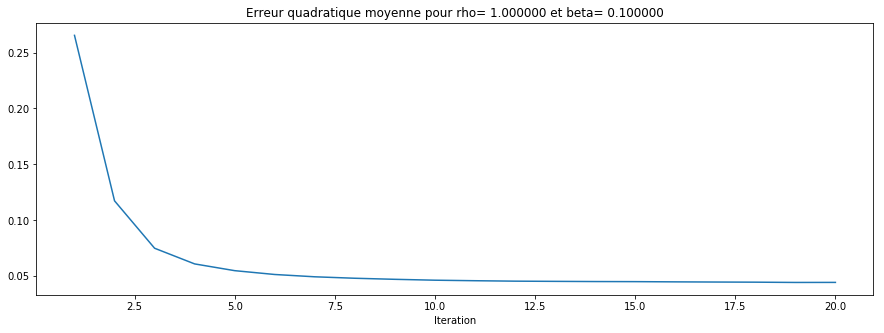

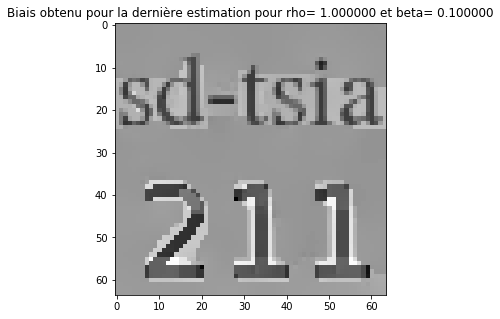

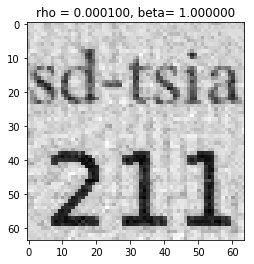

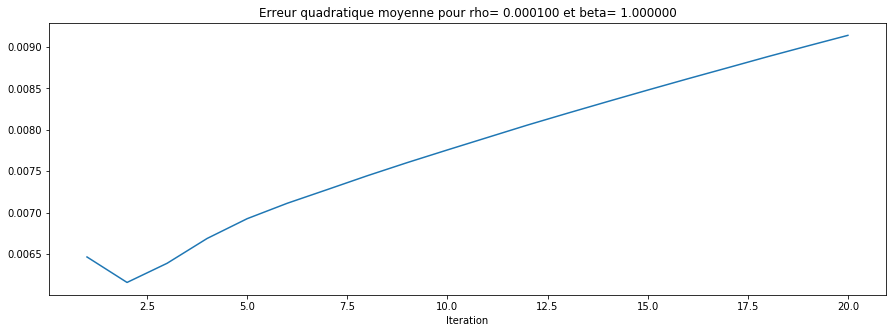

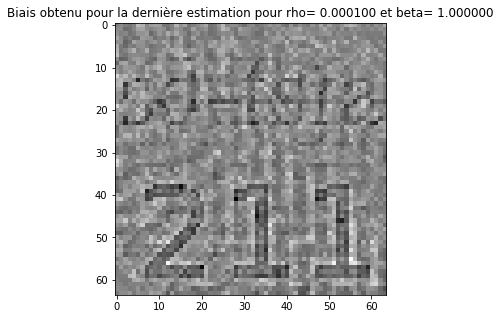

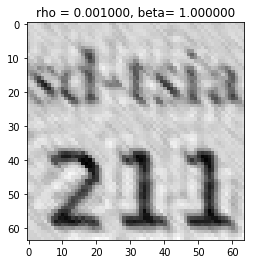

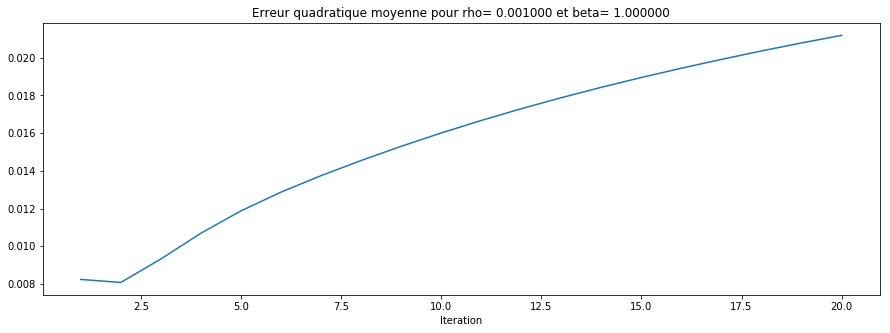

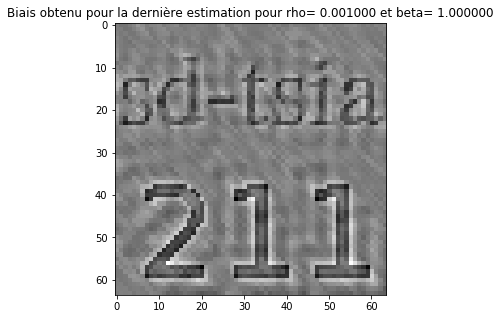

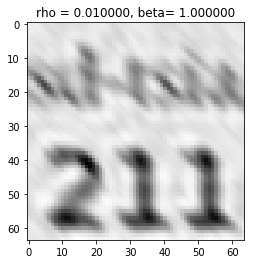

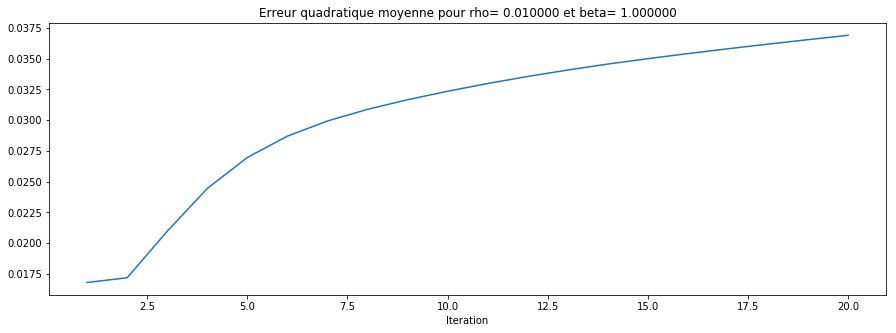

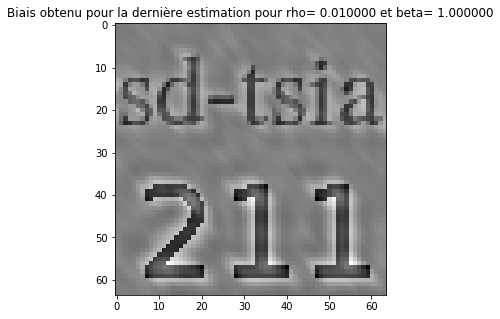

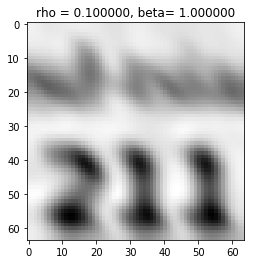

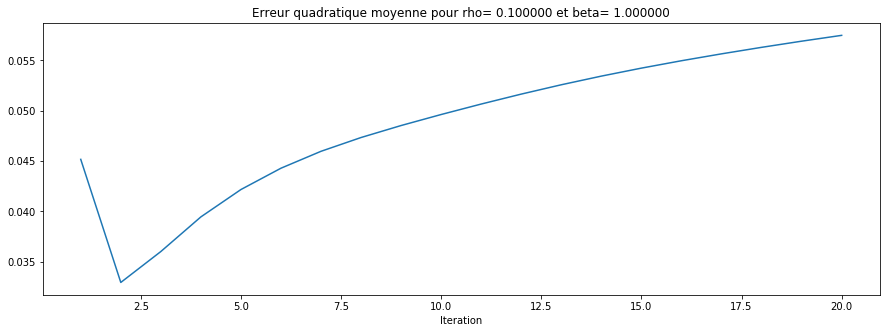

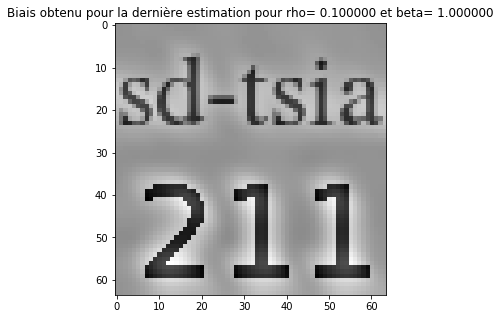

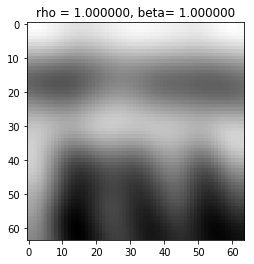

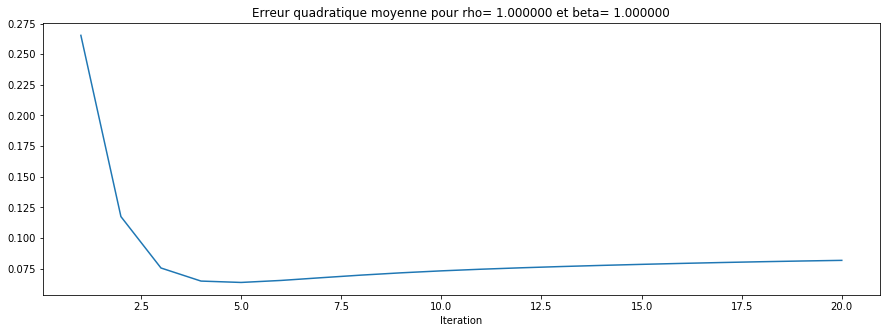

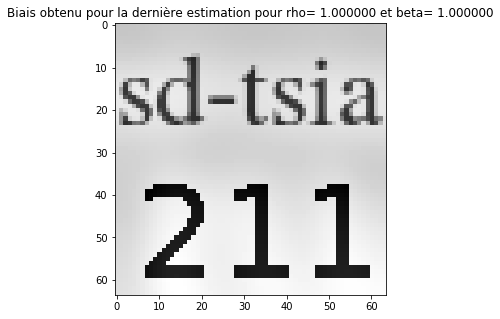

In [63]:
kmax=20
Lbeta=[1e-5,1e-4,1e-3,1e-2,0.1,1]
Lrho=[1e-4,1e-3,1e-2,0.1,1]

for i in Lbeta:
    for j in Lrho:
        x,y,eqm,L = ADMM(j,i)
        plt.figure(3, figsize=(15, 5))
        plt.title("Erreur quadratique moyenne pour rho= %f et beta= %f"%(j,i))
        plt.plot(abscisse, eqm)
        plt.xlabel("Iteration")
        plt.show()
        plt.figure(3, figsize=(15, 5))
        biais = X - x 
        plt.imshow(biais, cmap='gray')
        plt.title("Biais obtenu pour la dernière estimation pour rho= %f et beta= %f"%(j,i))
        plt.show()

On remarque que pour rho=0.01 et betha=0.001 et pour rho=0.001 et beta= 0.0001 on a une convergence assez rapide avec une erreur quadratique qui tend vers 0 et un résultat final assez satisfaisant.  On peut voir aussi d'autres résultats satisfaisants mais avec une convergence plus lente ( rho=0.1 et beta =0.001) mais aussi d'autres résultats complétement abérrants (erreur qui converge pas vers 0 ou biais trop important). Ceci met en valeur l'importance du choix de ces deux coefficients sur le temps d'éxécution (en nombre d'itérations) et sur le résultat final (biais,erreur, image reconstituée).